In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# probability model
from scipy.stats import multivariate_normal

In [16]:
# Use the I3D-based boundaries you generated (var-T, FNS ✗)
nalist = np.load(r"..\list\nalist_i3d.npy")
total_T = int(nalist[-1, 1])

# concat_UCF.npy was created via np.memmap (raw float32 file), so load with memmap
train_data = np.memmap(r"..\..\C2FPL\concat_UCF.npy", dtype="float32", mode="r", shape=(total_T, 10, 2048))

print("nalist shape:", nalist.shape, " total_T:", total_T)
print("train_data shape:", train_data.shape)

nalist shape: (1609, 2)  total_T: 779951
train_data shape: (779951, 10, 2048)


In [17]:
# Sanity check: video-0 span in the concatenated memmap
a0, b0 = map(int, nalist[0])
print("video0 span:", (a0, b0), "T0:", b0-a0)

video0 span: (0, 171) T0: 171


In [18]:
new_repr = []
for i, (fromid, toid) in enumerate(nalist):
    new_repr.append(train_data[fromid:toid])

len(new_repr)

1609

In [19]:
nalist_i3d = np.load(r"..\list\nalist_i3d.npy")
from0, to0 = nalist_i3d[0]
print("nalist[0]:", from0, to0, "len=", to0-from0)

x0 = train_data[from0:to0]
print("slice x0:", x0.shape)        # 여기서 (171,10,2048) 나와야 정상

print("new_repr[0]:", new_repr[0].shape)


nalist[0]: 0 171 len= 171
slice x0: (171, 10, 2048)
new_repr[0]: (171, 10, 2048)


In [20]:
new_repr[i].shape

(151, 10, 2048)

In [21]:
def estimate_gauss(X):
    m = X.shape[0]   # using only first dimension as we know it has only one feature - l2 norm
    
    mu = np.mean(X, axis=0)
    var = np.cov(X.T)
    
    return mu, var

def covariance_mat(X):
    X = np.mean(X , axis= 1)
    X =  X.transpose(1,0)
    cov  = np.cov(X)

    return cov

def get_matrix(data):

    #l2_norm = np.sqrt(np.sum(np.square(data), axis=2))
    l2_norm = np.sum(np.square(data), axis=2)
    n_train_crop_l2_norm_mean = np.mean(l2_norm, axis= 1)

    return n_train_crop_l2_norm_mean


def diff_l2(new_repr):

    l2_norms = []
    for i in range(len(new_repr)):
        l2_norms.append(get_matrix(new_repr[i]))

    mean_v_l2 = []
    for i in range(len(l2_norms)):
        mean_v_l2.append(np.diff(l2_norms[i], n=1).max())
    return mean_v_l2


In [22]:
params = []
for i in range(len(new_repr)):

    param = get_matrix(new_repr[i])
    mu, var = estimate_gauss(param)

    params.append((mu, var, ))

In [23]:
np.array(params).shape

(1609, 2)

In [24]:
from sklearn.mixture import GaussianMixture
import time


gmm = GaussianMixture(n_components=2, max_iter=150, random_state=0, covariance_type='spherical')
# gmm_scores = gmm.score_samples(params)
labels = gmm.fit_predict(params)

y_gmm = gmm.fit_predict(params)
print(y_gmm.sum(), y_gmm.sum() / len(y_gmm))


score = y_gmm 
score = gmm.score_samples(params) 
pct_threshold = np.percentile(score, 3)
print(f'The threshold of the score is {pct_threshold:.2f}') 
res = np.array([1 if x < pct_threshold else 0 for x in score]) 
print(res.sum())

427 0.2653822249844624
The threshold of the score is -23.32
49


cluster1 count: 427 ratio: 0.2653822249844624
score threshold (p3): -23.3190, res count: 49 ratio: 0.030453697949036667


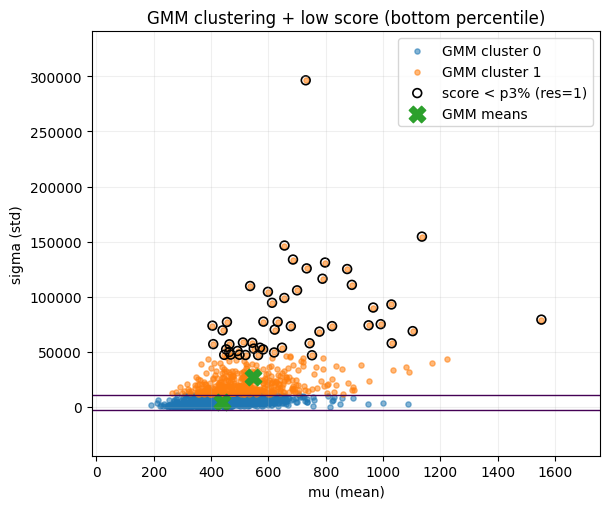

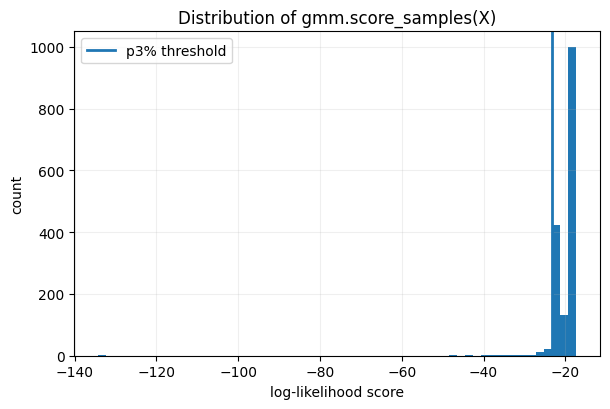

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# params: (N,2) (mu, sigma) 형태라고 가정
X = np.asarray(params, dtype=np.float32).reshape(-1, 2)

gmm = GaussianMixture(n_components=2, max_iter=150, random_state=0, covariance_type='spherical')
gmm.fit(X)

# 클러스터 라벨
y = gmm.predict(X)

# 로그 가능도 (값이 낮을수록 "밀도 낮음" = outlier 성향)
score = gmm.score_samples(X)

pct = 3
thr = np.percentile(score, pct)
res = (score < thr).astype(int)  # 1: 하위 pct% (너 코드의 res)

print("cluster1 count:", y.sum(), "ratio:", y.mean())
print(f"score threshold (p{pct}): {thr:.4f}, res count:", res.sum(), "ratio:", res.mean())


# ---- (A) 산점도: 클러스터 + res 강조 + boundary ----
plt.figure(figsize=(6.2, 5.2))

# 클러스터별 표시
plt.scatter(X[y==0,0], X[y==0,1], s=14, alpha=0.55, label="GMM cluster 0")
plt.scatter(X[y==1,0], X[y==1,1], s=14, alpha=0.55, label="GMM cluster 1")

# res(하위 3%)는 테두리 크게 표시
plt.scatter(X[res==1,0], X[res==1,1], s=40, facecolors='none', edgecolors='k', linewidths=1.2,
            label=f"score < p{pct}% (res=1)")

# GMM 평균 표시
means = gmm.means_
plt.scatter(means[:,0], means[:,1], s=140, marker="X", label="GMM means")

# decision boundary (predict가 바뀌는 선)
xmin, xmax = X[:,0].min(), X[:,0].max()
ymin, ymax = X[:,1].min(), X[:,1].max()
padx = 0.15 * (xmax - xmin + 1e-6)
pady = 0.15 * (ymax - ymin + 1e-6)

xs = np.linspace(xmin-padx, xmax+padx, 220)
ys = np.linspace(ymin-pady, ymax+pady, 220)
XX, YY = np.meshgrid(xs, ys)
grid = np.c_[XX.ravel(), YY.ravel()]
Z = gmm.predict(grid).reshape(XX.shape)

plt.contour(XX, YY, Z, levels=[0.5], linewidths=1)

plt.title("GMM clustering + low score (bottom percentile)")
plt.xlabel("mu (mean)")
plt.ylabel("sigma (std)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


# ---- (B) score_samples 분포: threshold가 어디인지 ----
plt.figure(figsize=(6.2, 4.2))
plt.hist(score, bins=60)
plt.axvline(thr, linewidth=2, label=f"p{pct}% threshold")
plt.title("Distribution of gmm.score_samples(X)")
plt.xlabel("log-likelihood score")
plt.ylabel("count")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [26]:
abnormal_portion = np.where(labels == 1)[0]
normal_portion = np.where(labels == 0)[0]
normal_portion.shape, abnormal_portion.shape

((1182,), (427,))

In [27]:
n_params = np.array(params)[normal_portion]
a_params = np.array(params)[abnormal_portion]
n_params.shape, a_params.shape

((1182, 2), (427, 2))

In [28]:
abag = list(zip(list(np.array(params)[abnormal_portion]), abnormal_portion))
nbag = list(zip(list(np.array(params)[normal_portion]), normal_portion))
len(abag), len(nbag)

(427, 1182)

In [29]:
print("len(nbag):", len(nbag))
print("type(nbag[0]):", type(nbag[0]))

# nbag[0]이 튜플/리스트면 feature가 보통 [0]에 있음
try:
    x0 = nbag[0][0]
    print("type(nbag[0][0]):", type(x0))
    print("shape(nbag[0][0]):", np.array(x0).shape)
except Exception as e:
    print("nbag[0][0] 접근 실패:", e)
    print("shape(nbag[0]):", np.array(nbag[0]).shape)


len(nbag): 1182
type(nbag[0]): <class 'tuple'>
type(nbag[0][0]): <class 'numpy.ndarray'>
shape(nbag[0][0]): (2,)


In [30]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.mixture import GaussianMixture

In [31]:

nu = 1.0
step = 1
import time
start = time.time()
while len(abag) / len(nbag) < nu:
    
    temp_bag = nbag
    X = np.vstack([np.asarray(t[0], dtype=np.float32).reshape(-1) for t in temp_bag])  # (N, 2)
    y_gmm = gmm.fit_predict(X)
    score = gmm.score_samples(X)

    pct_threshold = np.percentile(score, 3) 
    res = np.array([1 if x < pct_threshold else 0 for x in score]) 
    print(f'The threshold of the score in step {step} is {pct_threshold:.2f}, abnormal part: {res.sum()}') 
    
    abnormal_portion = np.where(res == 1)[0]
    normal_portion = np.where(res == 0)[0]
    # abnormal_portion / normal_portion 은 index 배열 (np.where 결과)
    abag += [temp_bag[i] for i in abnormal_portion.tolist()]
    nbag  = [temp_bag[i] for i in normal_portion.tolist()]
    step += 1

print(time.time() - start)

The threshold of the score in step 1 is -19.88, abnormal part: 36
The threshold of the score in step 2 is -19.53, abnormal part: 35
The threshold of the score in step 3 is -19.18, abnormal part: 34
The threshold of the score in step 4 is -19.05, abnormal part: 33
The threshold of the score in step 5 is -18.95, abnormal part: 31
The threshold of the score in step 6 is -18.98, abnormal part: 31
The threshold of the score in step 7 is -18.87, abnormal part: 30
The threshold of the score in step 8 is -18.74, abnormal part: 29
The threshold of the score in step 9 is -18.47, abnormal part: 28
The threshold of the score in step 10 is -18.30, abnormal part: 27
The threshold of the score in step 11 is -18.24, abnormal part: 27
The threshold of the score in step 12 is -18.13, abnormal part: 26
The threshold of the score in step 13 is -17.96, abnormal part: 25
0.14652299880981445


In [32]:
print(np.where(np.array([x[1] for x in abag]) < 810)[0].shape, len([x[1] for x in abag]))
print('correctness acc: ', np.where(np.array([x[1] for x in abag]) < 810)[0].shape[0] / len([x[1] for x in abag]))

(442,) 819
correctness acc:  0.5396825396825397


In [33]:
print(np.where(np.array([x[1] for x in nbag]) > 810)[0].shape, len([x[1] for x in nbag]))
print('correctness acc: ', np.where(np.array([x[1] for x in nbag]) > 810)[0].shape[0] / len([x[1] for x in nbag]))

(422,) 790
correctness acc:  0.5341772151898734


In [34]:
temp = [k[1] for k in sorted([(x[1], 1.0) for x in abag] + [(x[1], 0.0) for x in nbag], key=lambda z: z[0])]
sum(temp), len(temp)

(819.0, 1609)

In [35]:
# temp_repo: 길이 1609, 1=abnormal, 0=normal
temp_repo = np.array([k[1] for k in sorted(([(x[1],1.0) for x in abag] + [(x[1],0.0) for x in nbag]),
                                          key=lambda z: z[0])], dtype=np.int32)


X shape: (1609, 2)  y: (1609,) anom ratio: 0.5090118085767558


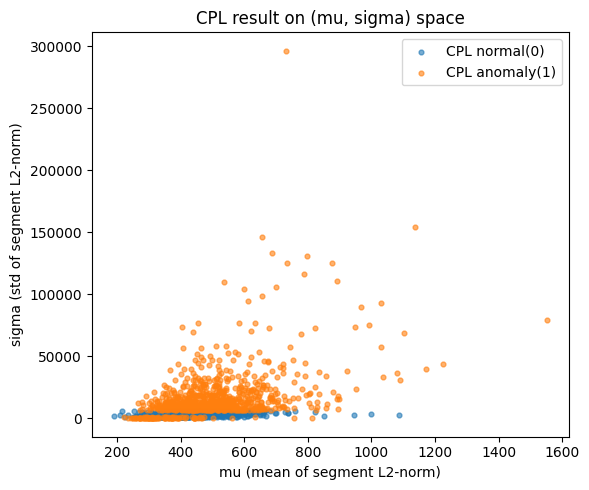

In [36]:
#cpl 결과 시각화
#(mu, sigma) 산점도
import numpy as np
import matplotlib.pyplot as plt

# params: list of (mu, sigma) or (mu, var) 튜플들
X = np.asarray(params, dtype=np.float32).reshape(-1, 2)

# temp: CPL 최종 pseudo video label (0/1), 길이 = len(X)

y = temp_repo.astype(int)

print("X shape:", X.shape, " y:", y.shape, "anom ratio:", y.mean())


plt.figure(figsize=(6,5))
plt.scatter(X[y==0, 0], X[y==0, 1], s=12, alpha=0.6, label="CPL normal(0)")
plt.scatter(X[y==1, 0], X[y==1, 1], s=12, alpha=0.6, label="CPL anomaly(1)")
plt.xlabel("mu (mean of segment L2-norm)")
plt.ylabel("sigma (std of segment L2-norm)")   # 네 코드에선 var 변수지만 std를 쓰고 있음
plt.title("CPL result on (mu, sigma) space")
plt.legend()
plt.tight_layout()
plt.show()


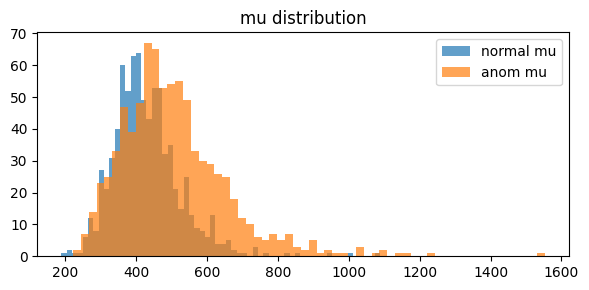

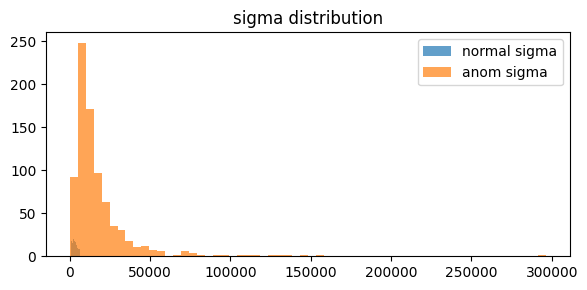

In [37]:
plt.figure(figsize=(6,3))
plt.hist(X[y==0,0], bins=60, alpha=0.7, label="normal mu")
plt.hist(X[y==1,0], bins=60, alpha=0.7, label="anom mu")
plt.title("mu distribution"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.hist(X[y==0,1], bins=60, alpha=0.7, label="normal sigma")
plt.hist(X[y==1,1], bins=60, alpha=0.7, label="anom sigma")
plt.title("sigma distribution"); plt.legend(); plt.tight_layout(); plt.show()


In [38]:
pred_ab = set(np.where(temp_repo == 1)[0])
pred_no = set(np.where(temp_repo == 0)[0])

gt_ab = set(range(0, 811))          # 0-810 이상
gt_no = set(range(811, 1610))    # 811-1609 정상

tp = len(pred_ab & gt_ab)
fp = len(pred_ab & gt_no)
fn = len(pred_no & gt_ab)
tn = len(pred_no & gt_no)

print("TP FP FN TN:", tp, fp, fn, tn)
print("precision:", tp / max(tp+fp,1))
print("recall:", tp / max(tp+fn,1))


TP FP FN TN: 443 376 368 422
precision: 0.5409035409035409
recall: 0.5462392108508015


In [39]:
# normal set creation
normal_set = {}

for i in range(len(new_repr)):
    if temp[i] == 0.0:
        normal_set[i] = new_repr[i]

In [40]:
# abnormal set creation
abnormal_set = {}
for i in range(len(new_repr)):
    if temp[i] == 1.0:
        abnormal_set[i] = new_repr[i]

In [41]:
l2_norms_N = np.empty(0,)
for (idel, sample) in normal_set.items():
    
    # print(sample.shape)
    

    l2_norms_N = np.append(l2_norms_N,get_matrix(sample))

In [42]:
len(normal_set), len(abnormal_set)

(790, 819)

In [43]:
mu_GMM, var_GMM = estimate_gauss(np.array(l2_norms_N))

In [44]:
# probability model
from scipy.stats import multivariate_normal
p = multivariate_normal(mu_GMM, var_GMM)

In [45]:
ground_truth = {} 
length = 0.2 
for (idel, sample) in abnormal_set.items(): 

    # feature extraction 
    # sample_matrix = np.sum(np.square(sample), axis=1)  # for just l2
    sample_matrix = get_matrix(sample)
    
    # get p values
    probs = p.pdf(sample_matrix)
    temp_list = []
    temp_list += [0.0] * len(probs)
    
    window_size = int(len(probs) * length)  # fixed
    temp = []
    for idx in range(0, len(probs) - window_size + 1):
        arr = 0
        for i in range(idx, idx + window_size - 1):
            arr += abs(probs[i+1] - probs[i])
        temp.append(arr)

    for i in range(temp.index(max(temp)), temp.index(max(temp)) + window_size):
        temp_list[i] = 1.0

    ground_truth[idel] = temp_list

In [46]:
final_gt = []
abnormal_gt = []
for i in range(len(new_repr)):
    if i in normal_set.keys():
        final_gt += [0.0] * new_repr[i].shape[0]
    else:
        final_gt += ground_truth[i]
        abnormal_gt+= ground_truth[i]

In [47]:
len(final_gt)

779951

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def plot_repo_fpl(sample, p, label_list, length=0.2, alpha=0.05, title=""):
    """
    sample: 비디오 feature (T, ...) -> get_matrix(sample)로 (T,) 또는 (T, d)로 바뀌는 형태
    p: scipy.stats multivariate_normal (p.pdf 가능)
    label_list: ground_truth[idel] = temp_list (길이 T, 0/1)
    length: repo 코드의 length(윈도우 비율)
    alpha: 참고용 significance level line (repo는 이걸 쓰진 않지만 비교용)
    """

    # p-value 다시 계산
    sample_matrix = get_matrix(sample)
    probs = np.asarray(p.pdf(sample_matrix), dtype=np.float64)

    y = np.asarray(label_list, dtype=np.int32)
    T = len(probs)
    assert len(y) == T, (len(y), T)

    x = np.arange(T)

    fig, ax = plt.subplots(2, 1, figsize=(12,4), sharex=True)

    # (1) p-value + alpha + 라벨=1 구간 음영
    ax[0].plot(x, probs, linewidth=1)
    ax[0].axhline(alpha, linestyle="--", linewidth=1)
    ax[0].fill_between(x, probs.min(), probs.max(), where=(y==1), alpha=0.2, label="label==1 window")
    ax[0].set_ylabel("p-value (pdf)")
    ax[0].set_title(title)
    ax[0].legend()

    # (2) 라벨 타임라인
    ax[1].step(x, y, where="post", linewidth=2, label="pseudo label")
    ax[1].set_ylim(-0.1, 1.1)
    ax[1].set_ylabel("label")
    ax[1].set_xlabel("segment index")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    # 선택 구간 출력(연속 1 구간)
    idx1 = np.where(y==1)[0]
    if idx1.size > 0:
        print(f"label==1 span: [{idx1[0]}, {idx1[-1]}]  len={idx1.size}/{T}  (~{length*100:.0f}%)")
    else:
        print("label==1 span: (none)")


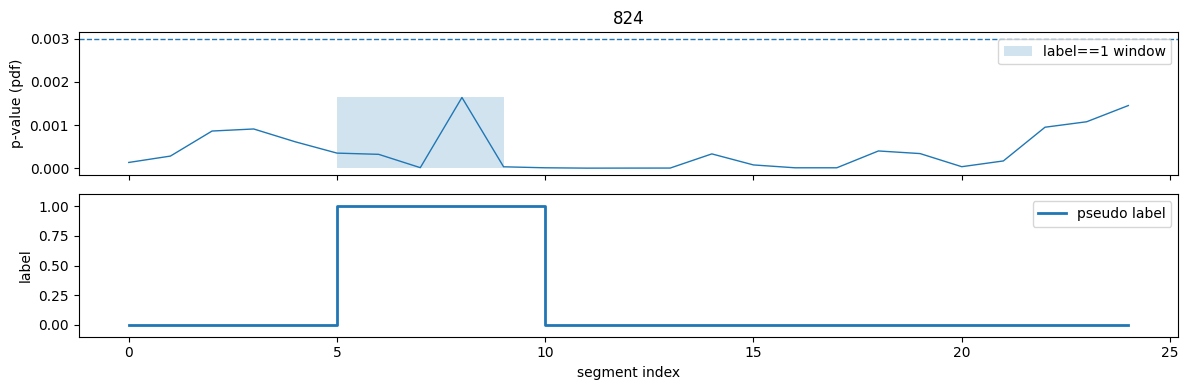

label==1 span: [5, 9]  len=5/25  (~20%)


In [88]:
idel = list(abnormal_set.keys())[450]  # 원하는 인덱스로 바꿔도 됨
sample = abnormal_set[idel]
label_list = ground_truth[idel]      # repo 코드의 temp_list

plot_repo_fpl(sample, p, label_list, length=0.2, alpha=0.003, title=str(idel))


In [51]:
final_gt = np.array(final_gt, dtype=np.float32)

print("final_gt shape:", final_gt.shape, "sum:", final_gt.sum())
np.save(r"..\Unsup_labels\UCF_unsup_labels_i3d_varT.npy", final_gt)

final_gt shape: (779951,) sum: 57267.0


In [52]:
print("final abag:", len(abag), "nbag:", len(nbag), "ratio:", len(abag)/len(nbag))


final abag: 819 nbag: 790 ratio: 1.0367088607594936


In [53]:
pseudo = np.load("../Unsup_labels/UCF_unsup_labels_i3d_varT.npy")
print(pseudo.shape, pseudo.dtype)
print("mean:", pseudo.mean(), "sum:", pseudo.sum()) #sum 결과 = 전체 스니펫(779951개) 중 약 5.7만 개를 이상(1)으로 찍었음을 알 수 있음. 
print("ones ratio:", pseudo.mean())


(779951,) float32
mean: 0.07342384 sum: 57267.0
ones ratio: 0.07342384


In [ ]:
np.save('unsupervised_PL/'+'UCF_labels_entropy_1.npy', final_gt) #UCF
# np.save('Unsup_labels/'+'XD_I3D_unsup_labels_10_V2_GMM.npy', final_gt) #XD